# Plots of Blob Detector Algorithm on Comet Using Spark

In [13]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import glob
import re

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
def SparkLogToDataFrame(filename):
    import json
    import pandas
    import numpy as np

    columns=['StageID','TaskId','ExecutorID','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','GettingResultTime','ResultSerializationTime','FinishTime','ResultSize']

    stat_file=open(filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((1,11),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0,0] = int(stat['Stage ID'])
            data_point[0,1] = int(stat['Task Info']['Task ID'])
            data_point[0,2] = int(stat['Task Info']['Executor ID'])
            data_point[0,3] = int(stat['Task Info']['Launch Time'])
            data_point[0,5] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[0,6] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[0,7] = int(stat['Task Info']['Finish Time'])-int(stat['Task Info']['Getting Result Time']) if int(stat['Task Info']['Getting Result Time'])!=0 else 0 
            data_point[0,8] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[0,9] = int(stat['Task Info']['Finish Time'])
            data_point[0,10] = int(stat['Task Metrics']['Result Size'])
            
            data_point[0,4]= data_point[0,9]-data_point[0,3]-data_point[0,5]-data_point[0,6]-data_point[0,8]-data_point[0,7]
            data_case = pandas.DataFrame(data_point,columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data

In [15]:
folders = glob.glob('*/app-*')
plotting_df = pd.DataFrame(columns=['Nodes','Time_ms', 'Scaling'])
for name in folders:
    df = SparkLogToDataFrame(name)
    time = (df['FinishTime'].max()-df['LaunchTime'].min()) / 1000.
    node = int(re.findall('\d+', name)[0])
    if 'W' in name:
        scale = 'W'
    elif 'S' in name:
        scale = 'S'
    else:
        scale = 'WS'
    plotting_df.loc[len(plotting_df)]=[node, time, scale]
    
plotting_df.to_csv('spark_filtered_data_nonhomogeneous_images.csv')

Calculate the mean and standard deviation of Spark times

In [16]:
test_iterations = 4
tests = len(plotting_df)
num_tests = tests / test_iterations 

times_spark = pd.DataFrame(columns=['nodes','time'])
scaling = list()
stderr = list()
for i in range(int(num_tests)):
    times_spark.loc[i] = plotting_df[i*test_iterations : (i+1)*test_iterations].mean().values
    scaling.append(plotting_df['Scaling'][i*test_iterations])
    stderr.append(plotting_df['Time_ms'][i*test_iterations : (i+1)*test_iterations].std()) 
    
times_spark['scaling'] = scaling
times_spark['stderr'] = stderr

times_spark = times_spark.sort_values(by=['nodes']).set_index(['nodes'])

Plot mean Spark mean times

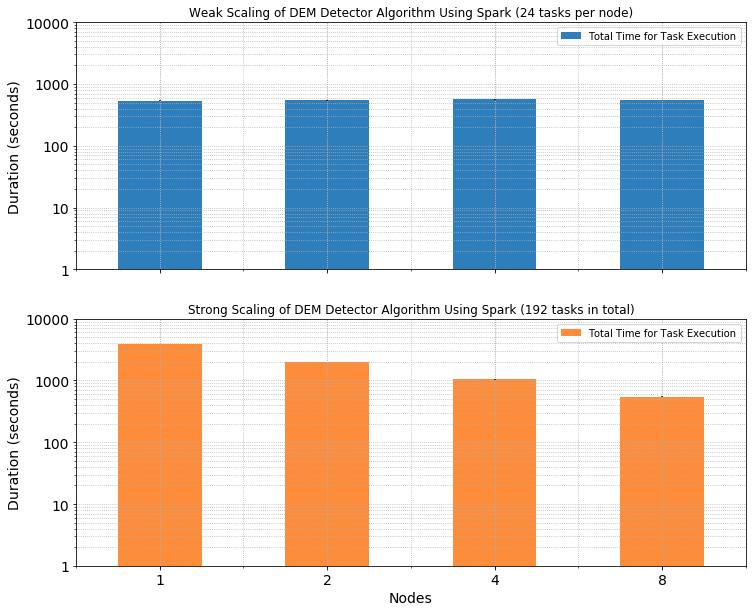

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
fig.set_size_inches(12,10)

weak_mean    = times_spark.where((times_spark['scaling'] == 'W') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'stderr'])
weak_error   = times_spark.where((times_spark['scaling'] == 'W') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'time'])['stderr']
strong_mean  = times_spark.where((times_spark['scaling'] == 'S') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'stderr'])
strong_error = times_spark.where((times_spark['scaling'] == 'S') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'time'])['stderr']

yticks = [1, 10, 100, 1000, 10000]
yticklabels = [str(ytick) for ytick in yticks]

blues   = cm.get_cmap(plt.get_cmap('Blues'))
greens  = cm.get_cmap(plt.get_cmap('Greens'))
reds    = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys   = cm.get_cmap(plt.get_cmap('Greys'))

weak_client_color = blues(0.7)
weak_task_color = blues(0.4)
strong_client_color = oranges(0.5)
strong_task_color = oranges(0.2)

weak_kwargs    = {
                 'kind'     : 'bar',
                 'log'      : True,
                 'fontsize' : 14,
                 'title'    : 'Weak Scaling of Blob Detector Detector Algorithm Using Spark (24 tasks per node)',
                 'ax'       : axes[0],
                 'yerr'     : weak_error,
                 'color'    : [weak_client_color, weak_task_color]
                  }
strong_kwargs  = {
                 'kind'     : 'bar',
                 'log'      : True,
                 'fontsize' : 14,
                 'title'    : 'Strong Scaling of Blob Detector Detector Algorithm Using Spark (192 tasks in total)',
                 'ax'       : axes[1],
                 'yerr'     : strong_error,
                 'color'    : [strong_client_color, strong_task_color]
                }

weak_scale_plot = weak_mean.plot(**weak_kwargs)
weak_scale_plot.set_ylabel('Duration (seconds)', fontsize=14)
weak_scale_plot.set_ylim(bottom=min(yticks), top=max(yticks))
weak_scale_plot.set_yticks(yticks)
weak_scale_plot.set_yticklabels(yticklabels, fontsize=14)
weak_scale_plot.grid('on', which='both', linestyle=':')
axes[0].legend(['Total Time for Task Execution'])

strong_scale_plot = strong_mean.plot(**strong_kwargs)
strong_scale_plot.set_ylabel('Duration (seconds)', fontsize=14)
strong_scale_plot.set_ylim(bottom=min(yticks), top=max(yticks))
strong_scale_plot.set_yticks(yticks)
strong_scale_plot.set_yticklabels(yticklabels, fontsize=14)
strong_scale_plot.set_xticklabels(['1','2','4','8'], rotation=0, fontsize=14)
strong_scale_plot.grid('on', which='both', linestyle=':')
strong_scale_plot.set_xlabel('Nodes', fontsize=14)
axes[1].legend(['Total Time for Task Execution'])